In [1]:
import pandas as pd
import numpy as np
import sklearn 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import lime
import shap
import matplotlib as plot
import sklearn.metrics
import sklearn.datasets
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import r2_score

/home/teadem/.local/lib/python3.6/site-packages/numba/core/errors.py:154: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


In [2]:
# data = sklearn.datasets.load_breast_cancer()
# X,y = data.

In [3]:
def loadDataset(dataset):
    if dataset == "breast cancer":
        X, y = sklearn.datasets.load_breast_cancer(return_X_y=True)
        data = sklearn.datasets.load_breast_cancer()
        featureName = data.feature_names
        return X, y,featureName
    elif dataset == "wine":
        wine = sklearn.datasets.load_wine()
        X = wine.data
        y = wine.target
        target_names = wine.target_names
        feature_names = wine.feature_names

        return X,y,target_names,feature_names
    else: 
        return None

In [4]:
def split_train_test(X,y,test_size=0.3,randomstate=42,scale=False):
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=test_size,random_state=randomstate)
    return X_train,X_test,y_train,y_test


In [5]:
# x = X_test[0]
# coefs = LR_shap.values[0]
# base = np.mean(X_test,axis=0)
# LR_model.predict_proba(x.reshape(1,-1))
# monotonicity(LR_model, x, coefs, LR_model.predict_proba(x.reshape(1,-1)))

In [6]:
def train_model(model, X,y):
    if model == "Logistic Regression":
        lr = LogisticRegression(max_iter=10000)
        lr.fit(X,y)
        return lr
    elif model == "Random Forest Classifier":
        rf_c = RandomForestClassifier()
        rf_c.fit(X,y)
        return rf_c
    elif model == "SVC":
        svc = SVC(
            kernel = 'rbf',
            C=1,
            probability=True,
            gamma = 0.1,
            decision_function_shape='ovr',  # n_cls trained with data from one class as postive and remainder of data as neg
            random_state = 0,
        )
        svc.fit(X,y)
        return svc
    else:
        return None


In [7]:

def Explanation(explainer,model,X,X_ref):
    
    if explainer == "SHAP":
        exp = shap.Explainer(model, X_ref)
        shap_vals = exp(X)
        base_val = shap_vals.base_values 
        return shap_vals,base_val
    elif explainer == "Kernel SHAP":
        exp = shap.KernelExplainer(model, X_ref)
        shap_vals = exp.shap_values(X)
        expected_val = exp.expected_value
        return shap_vals,expected_val
    elif explainer == "Tree SHAP":
        exp = shap.TreeExplainer(model,X_ref)
        shap_vals = exp(X)
        return shap_vals
    elif explainer == "LIME":
       
        lime_exp = lime.lime_tabular.LimeTabularExplainer(
            X,
            mode='classification') 
        exp_lime = []
        for x in X:
            ex = lime_exp.explain_instance(x, 
                model, num_features=x.shape[0])
            exp_lime.append(x)
        return exp_lime
    elif explainer == "LIME-SHAP":
        exp_lime = []
        
        lime_explainer_shap = shap.other.LimeTabular(model,X,mode = 'classification')
        lime_attribs = lime_explainer_shap.attributions(X,num_features=X.shape[1])
        return lime_attribs
    else:
        return None
'''lime_exp = lime.lime_tabular.LimeTabularExplainer(
    X_train_np,
    feature_names=columns ,
    class_names=['feature_names'], 
    verbose=True, 
    mode='regression')'''

"lime_exp = lime.lime_tabular.LimeTabularExplainer(\n    X_train_np,\n    feature_names=columns ,\n    class_names=['feature_names'], \n    verbose=True, \n    mode='regression')"

In [8]:
def visualize_shap(X, shap_value,expected_value,type_of_Vis,explainer_type):
    shap.initjs()
    if explainer_type == "shap":
        if type_of_Vis == "waterfall":
            shap.plots.waterfall(shap_value)
        elif type_of_Vis == "force plot":
            shap.initjs()
            shap.plots.force(shap_value)
        elif type_of_Vis == "beeswarm":
            shap.plots.beeswarm(shap_value)
        elif type_of_Vis == "bar plot":
            shap.plots.bar(shap_value)
    elif explainer_type == "kernel shap":
        if type_of_Vis == "force plot":
            shap.force_plot(expected_value, shap_value, X)
#         elif
#             shap.plots.bar(shap_value)
        elif type_of_Vis == "heatmap":
            shap.plots.heatmap(shap_value)
        elif type_of_Vis == "summary plot":
            shap.summary_plot(shap_value, X)


In [9]:
def visualize1(model,X, shap_value,type_of_Vis,local_global):
    if local_global == "local":
        shap.initjs()
        if type_of_Vis == "force":
            shap.plots.force(shap_value)
        
    elif local_global == "global":
        if type_of_Vis == "plot bar":
            shap.plots.bar(shap_value)
        elif type_of_Vis == "heatmap":
            shap.plots.heatmap(shap_value)
        elif type_of_Vis == "summary plot":
            shap.summary_plot(shap_value, X)


In [10]:
import matplotlib.pyplot as pp
def plot(x):
  pp.plot(x,'-o')
  pp.show()

In [11]:
# ar = np.argsort(-coefs)  #argsort returns indexes of values sorted in increasing order; so do it for negated array
#     pred_probs = np.zeros(x.shape[0])
#     for ind in np.nditer(ar):
#         x_copy = x.copy()
#         x_copy[ind] = base[ind]
#         x_copy_pr = model.predict_proba(x_copy.reshape(1,-1))
#         pred_probs[ind] = x_copy_pr[0][pred_class]

#     return -np.corrcoef(coefs, pred_probs)[0,1]

In [12]:
def faithfulness_metrics_cls(model,x,coefs,base):
#     pred_class = np.argmax(model.predict_proba(np.transpose(x.reshape(-1,1))), axis=1)[0]
#     pred_prob_og = model.predict_proba(np.transpose(x.reshape(-1,1)))
#     ar = np.argsort(-coefs)  #argsort returns indexes of values sorted in increasing order; so do it for negated array
#     pred_probs = np.zeros(x.shape[0])
#     diff = []
#     for ind in np.nditer(ar):
#         x_copy = x.copy()
#         x_copy[ind] = base[ind]
        
#         x_copy_pr = model.predict_proba(x_copy.reshape(1,-1))
#         pred_probs[ind] = x_copy_pr[0][pred_class]
#         # print(pred_probs)
#         # print(pred_class)

#     return -np.corrcoef(coefs, pred_probs-pred_prob_og)[0,1]
    pred_class = np.argmax(model.predict_proba(x.reshape(1,-1)), axis=1)[0]
    p = np.amax(model.predict_proba(x.reshape(1,-1)))
#     print("og pred",p)
    #find indexs of coefficients in decreasing order of value
    ar = np.argsort(-coefs)  #argsort returns indexes of values sorted in increasing order; so do it for negated array
    pred_probs = np.zeros(x.shape[0])
    isPos = [-1 for i in range(len(ar))]
    diff = np.zeros(x.shape[0])
    for ind in np.nditer(ar):
        if coefs[ind]<0:
            isPos[ind] = -1
        else:
            isPos[ind] = 1
        x_copy = x.copy()
        x_copy[ind] = base[ind]
        x_copy_pr = model.predict_proba(x_copy.reshape(1,-1))
        pred_probs[ind] = x_copy_pr[0][pred_class]
#         print(pred_probs)
        diff[ind]=p - pred_probs[ind]
#     print(coefs, np.array(diff))

    return -np.corrcoef(coefs, -np.array(isPos)*np.array(diff))[0,1]

In [13]:
x=np.array([[1,2,3],[2,3,4]])
x[1:,]

array([[2, 3, 4]])

In [14]:
base = np.mean(x, axis=0)
base

array([1.5, 2.5, 3.5])

In [15]:
def monotonicity(model, x, coefs, base):
    pred_class = np.argmax(model.predict_proba(x.reshape(1,-1)), axis=1)[0]
    x_copy = base.copy()
    #find indexs of coefficients in increasing order of value
    ar = np.argsort(coefs)
#     print(coefs)
    isPos = [False for i in range(len(ar))]
    pred_probs = np.zeros(x.shape[0])
    for ind in np.nditer(ar):
        if coefs[ind]<0:
            isPos[ind] = False
        else:
            isPos[ind] = True
        x_copy[ind] = x[ind]
        x_copy_pr = model.predict_proba(x_copy.reshape(1,-1))
        pred_probs[ind] = x_copy_pr[0][pred_class]
    diff = np.diff(pred_probs[ar])
    final_ = []
    for i in range(len(diff)):
        if isPos[i] == False and diff[i] < 0:
            final_.append(True)
        elif isPos[i] == True and diff[i] >=0:
            final_.append(True)
        else:
            final_.append(False)
    return any(final_)

In [16]:
def metrics(model,X,shap_val,explainer_type,metrics_type,dataset):
    # cols = X.columns
    # if dataset == "boston":
    #   base1 = X[cols].mean()
    #   base1['ZN'] = int(round(X['ZN'].mean()))
    #   base1['CHAS'] = 0
    #   base1['RAD'] = int(round(X['RAD'].mean()))
    #   base = base1.values
    # else:
    base = np.mean(X,axis=0)
    if metrics_type == "faithfulness":
        faithfulness = []
        if explainer_type == "shap":
            for i in range(X.shape[0]):
                x = X[i,:]
                if type(shap_val) == np.ndarray:
                    coefs = shap_val[i]
                else:# print(shap_val[i])
                    coefs = shap_val[i].values
                f = faithfulness_metrics_cls(model, x, coefs, base)
                # print(f)
                faithfulness.append(f)
        elif explainer_type == "kernel shap":
            for i in range(X.shape[0]):
                x = X[i,:]
                # print(shap_val[i])
                if type(shap_val) == np.ndarray:
                    coefs = shap_val[i]
                else:# print(shap_val[i])
                    coefs = shap_val[i].values
#                 coefs = shap_val[i]
                f = faithfulness_metrics_cls(model, x, coefs, base)
                # print(f)
                faithfulness.append(f)
        elif explainer_type == "lime":
            for i in range(X.shape[0]):
                x = X[i,:]
                coefs = shap_val[i]
                f = faithfulness_metrics_cls(model, x, coefs, base)
                # print(f)
                faithfulness.append(f)
        plot(faithfulness)
        return np.array(faithfulness).mean()
    elif metrics_type == "monotonicity":
        mono = []
        if explainer_type == "shap":
            for i in range(X.shape[0]):
                x = X[i,:]
                if type(shap_val) == np.ndarray:
                    coefs = shap_val[i]
                else:# print(shap_val[i])
                    coefs = shap_val[i].values
#                 coefs = shap_val.values[i]
                f = monotonicity(model, x, coefs, base)
                mono.append(f)
        elif explainer_type == "lime":
            for i in range(X.shape[0]):
                x = X[i,:]
                coefs = shap_val[i]
                f = monotonicity(model, x, coefs, base)
                mono.append(f)
        return mono

In [21]:
def Main(dataset):
    if dataset == "wine":
        X,y,target_names,feature_names = loadDataset(dataset)
    else:
        X,y,feature_names = loadDataset(dataset)
    
    sc = StandardScaler()
    X_scaled = sc.fit_transform(X)
    X_train,X_test,y_train,y_test = train_test_split(X,y)
    X_trainS,X_testS,y_trainS,y_testS = train_test_split(X_scaled,y)

    LR_model = train_model("Logistic Regression",X_train,y_train)
    RF_model = train_model("Random Forest Classifier",X_train,y_train)
    SVC_model = train_model("SVC",X_trainS,y_trainS)

    print('R2 for Train)', RF_model.score( X_train, y_train ))
    print('R2 for Test (cross validation)', RF_model.score(X_test, y_test))
    
    print('R2 for Train)', LR_model.score( X_train, y_train ))
    print('R2 for Test (cross validation)', LR_model.score(X_test, y_test))
    
    print('R2 for Train)', SVC_model.score( X_trainS, y_trainS))
    
    predict_fnLR = lambda x:LR_model.predict_proba(x)[:,1]
    predict_fnRF = lambda x:RF_model.predict_proba(x)[:,1]
    predict_fnSVC = SVC_model.decision_function 

    X100 = shap.maskers.Independent(X, max_samples=100)
    X100_ = shap.utils.sample(X, 100)
    
    LR_shap,LR_baseVal = Explanation("SHAP",predict_fnLR,X_test[:50,],X100)
    LR_shap_k,LR_expected_val_k = Explanation("Kernel SHAP",predict_fnLR,X_test[:50,],X100_)
    LR_lime1 = Explanation("LIME",LR_model.predict_proba,X_test,X100)
    
    RF_shap, RF_baseVal = Explanation("SHAP",predict_fnRF,X_test[:50,],X100)
    RF_shap_k,RF_expected_val_k = Explanation("Kernel SHAP",predict_fnRF,X_test[:50,],X100_)
    RF_lime1 = Explanation("LIME",RF_model.predict_proba,X_test,X100)
    
    SVC_shap, SVC_baseVal = Explanation("SHAP",predict_fnSVC,X_testS[:50,],X100)
    SVC_shap_k,SVC_expected_val_k = Explanation("Kernel SHAP",predict_fnSVC,X_testS[:50,],X100_)
    SVC_lime1 = Explanation("LIME",SVC_model.predict_proba,X_testS,X100)
    
    ################ Visualization ####################
    #single instance
    print("single instance")
    idx = 1
    x_single = X_test[idx]
    x_single_S = X_testS[idx]
    print("--------------shap explainer -------------------")
    visualize_shap(x_single, LR_shap[idx],LR_baseVal[idx],"waterfall","shap")
    visualize_shap(x_single, RF_shap[idx],RF_baseVal[idx],"waterfall","shap")
    visualize_shap(x_single_S, SVC_shap[idx],SVC_baseVal[idx],"waterfall","shap")
    print("--------------kernel shap explainer-------------------")
#     visualize_shap(x_single, LR_shap[idx],LR_baseVal,"force plot","kernel shap")
#     visualize_shap(x_single, RF_shap[idx],RF_baseVal,"force plot","kernel shap")
#     visualize_shap(x_single_S, SVC_shap[idx],SVC_baseVal,"force plot","kernel shap")
    #multiple instances
    print("multiple instances")
    print("--------------shap explainer -------------------")
    x_multi = X_test[:50,]
    x_multi_S = X_testS[:50,]
    visualize_shap(x_multi, LR_shap,LR_baseVal,"barplot","shap")
    visualize_shap(x_multi, RF_shap,RF_baseVal,"barplot","shap")
    visualize_shap(x_multi_S, SVC_shap,SVC_baseVal,"barplot","shap")
    print("beeswarm")
    visualize_shap(x_multi, LR_shap,LR_baseVal,"beeswarm","shap")
    visualize_shap(x_multi, RF_shap,RF_baseVal,"beeswarm","shap")
    visualize_shap(x_multi_S, SVC_shap,SVC_baseVal,"beeswarm","shap")
    print("--------------kernel shap explainer-------------------")
    visualize_shap(x_single, LR_shap,LR_baseVal,"summary plot","kernel shap")
    visualize_shap(x_single, RF_shap,RF_baseVal,"summary plot","kernel shap")
    visualize_shap(x_single_S, SVC_shap,SVC_baseVal,"summary plot","kernel shap")
    ################### evaluation#####################
    
    #faithfulness
    faithfulness_LR_shap= metrics(model=LR_model,X=X_test[:50,],shap_val=LR_shap,explainer_type="shap",metrics_type="faithfulness",dataset=dataset)
    print("Mean Faithfulness for shap Logistic reg:",np.mean(np.array(faithfulness_LR_shap)))
    faithfulness_LR_shap_k = metrics(model=LR_model,X=X_test[:50,],shap_val=LR_shap_k,explainer_type="kernel shap",metrics_type="faithfulness",dataset=dataset)
    print("Mean Faithfulness for kernel shap Logistic reg:",np.mean(np.array(faithfulness_LR_shap_k)))
    faithfulness_LR_lime = metrics(model=LR_model,X=X_test[:50,],shap_val=LR_lime1,explainer_type="lime",metrics_type="faithfulness",dataset=dataset)
    print("Mean Faithfulness for lime Logistic Reg:",np.mean(np.array(faithfulness_LR_lime)))
    faithfulness_RF_shap = metrics(model=RF_model,X=X_test[:50,],shap_val=RF_shap,explainer_type="shap",metrics_type="faithfulness",dataset=dataset)
    print("Mean Faithfulness for shap RF Classification:",np.mean(np.array(faithfulness_RF_shap)))
    faithfulness_RF_shap_k = metrics(model=RF_model,X=X_test[:50,],shap_val=RF_shap_k,explainer_type="kernel shap",metrics_type="faithfulness",dataset=dataset)
    print("Mean Faithfulness for kernel shap RF Classification:",np.mean(np.array(faithfulness_RF_shap_k)))
    faithfulness_RF_lime = metrics(model=LR_model,X=X_test[:50,],shap_val=RF_lime1,explainer_type="lime",metrics_type="faithfulness",dataset=dataset)
    print("Mean Faithfulness for lime RF Classification:",np.mean(np.array(faithfulness_RF_lime)))
    #TODO svc
#     pred_class1 = np.argmax(SVC_model.predict_proba(X_testS[:10,]), axis=1)
#     x = X_testS[:10,]
#     s=SVC_shap.values[:10,]
#     o = []
#     for i in range(x.shape[0]):
#         p = pred_class1[i]
#         o.append(s[i,:,p])
#     o_ = np.array(o)
    faithfulness_SVC_shap= metrics(model=SVC_model,X=X_testS[:10,],shap_val=SVC_shap,explainer_type="shap",metrics_type="faithfulness",dataset=dataset)
    print("Mean Faithfulness for lime RF Classification:",np.mean(np.array(faithfulness_SVC_shap)))
    #kernel shap
#     pred_class = np.argmax(SVC_model.predict_proba(X_testS[:10,]), axis=1)
#     x = X_testS[:10,]
#     sk=np.array(SVC_shap_k)[:10,]
#     ok = []
#     for i in range(x.shape[0]):
#         p = pred_class[i]
#         ok.append(sk[p,i,:])
#     o_k= np.array(ok)
    faithfulness_SVC_k_shap= metrics(model=SVC_model,X=X_testS[:10,],shap_val=SVC_shap_k,explainer_type="shap",metrics_type="faithfulness",dataset=dataset)
    print("Mean Faithfulness for lime RF Classification:",np.mean(np.array(faithfulness_SVC_k_shap)))
    #LIME
    faithfulness_SVC_lime= metrics(model=SVC_model,X=X_testS[:10,],shap_val=np.array(SVC_lime1),explainer_type="lime",metrics_type="faithfulness",dataset=dataset)
    print("Mean Faithfulness for lime RF Classification:",np.mean(np.array(faithfulness_SVC_lime)))
    
    monotonicity_LR_shap = metrics(model=LR_model,X=X_test[:10,],shap_val=LR_shap,explainer_type="shap",metrics_type="monotonicity",dataset=dataset)
    monotonicity_LR_shap_k = metrics(model=LR_model,X=X_test[:10,],shap_val=LR_shap_k ,explainer_type="shap",metrics_type="monotonicity",dataset=dataset)
    monotonicity_LR_lime = metrics(model=LR_model,X=X_test[:10,],shap_val=LR_lime1,explainer_type="lime",metrics_type="monotonicity",dataset=dataset)
    monotonicity_RF_shap = metrics(model=RF_model,X=X_test[:10,],shap_val=RF_shap,explainer_type="shap",metrics_type="monotonicity",dataset=dataset)
    monotonicity_RF_shap_k = metrics(model=RF_model,X=X_test[:10,],shap_val=RF_shap_k,explainer_type="shap",metrics_type="monotonicity",dataset=dataset)
    monotonicity_RF_lime = metrics(model=RF_model,X=X_test[:10,],shap_val=RF_lime1,explainer_type="lime",metrics_type="monotonicity",dataset=dataset)

    monotonicity_SVC_lime = metrics(model=SVC_model,X=X_testS[:10,],shap_val=SVC_lime1,explainer_type="lime",metrics_type="monotonicity",dataset=dataset)
    pred_class1 = np.argmax(SVC_model.predict_proba(X_testS[:10,]), axis=1)
    x = X_testS[:10,]
    s=SVC_shap.values[:10,]
    o = []
    for i in range(x.shape[0]):
        p = pred_class1[i]
        o.append(s[i,:,p])
    o_ = np.array(o)



    pred_class = np.argmax(SVC_model.predict_proba(X_testS[:10,]), axis=1)
    x = X_testS[:10,]
    sk=np.array(SVC_shap_k)[:10,]
    ok = []
    for i in range(x.shape[0]):
        p = pred_class[i]
        ok.append(sk[p,i,:])
    o_k= np.array(ok)


    monotonicity_SVC_shap = metrics(model=SVC_model,X=X_testS[:10,],shap_val=o_,explainer_type="shap",metrics_type="monotonicity",dataset=dataset)
    monotonicity_SVC_shap_k = metrics(model=SVC_model,X=X_testS[:10,],shap_val=o_k,explainer_type="shap",metrics_type="monotonicity",dataset=dataset)


In [ ]:
Main("breast cancer")

R2 for Train) 1.0
R2 for Test (cross validation) 0.993006993006993
R2 for Train) 0.9577464788732394
R2 for Test (cross validation) 0.9790209790209791
R2 for Train) 0.9835680751173709


  0%|          | 0/50 [00:00<?, ?it/s]

Permutation explainer: 51it [00:14,  1.10it/s]                        


  0%|          | 0/50 [00:00<?, ?it/s]

In [20]:
X,y,feature_names = loadDataset("breast cancer")
sc = StandardScaler()
X_scaled = sc.fit_transform(X)
X_train,X_test,y_train,y_test = train_test_split(X,y)
X_trainS,X_testS,y_trainS,y_testS = train_test_split(X_scaled,y)

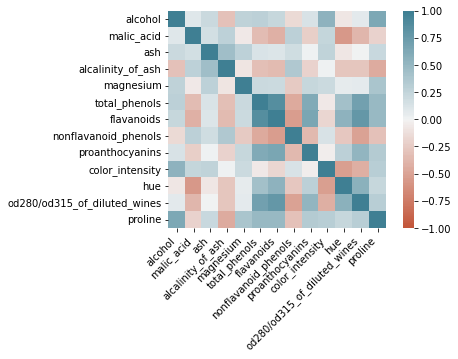

In [26]:
import seaborn as sns
data = pd.DataFrame(X,columns = feature_names)
corr = data.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [18]:
dataset1 = "breast cancer"
X1,y1,fN = loadDataset(dataset1)
data = pd.DataFrame(X1,columns = fN)
corr = data.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

NameError: name 'sns' is not defined

numpy.ndarray

In [21]:
X.shape

(569, 30)

In [22]:
X_train[:10,].shape

(10, 30)

In [23]:
LR_model = train_model("Logistic Regression",X_train,y_train)
RF_model = train_model("Random Forest Classifier",X_train,y_train)
SVC_model = train_model("SVC",X_trainS,y_trainS)

In [24]:
print('R2 for Train)', RF_model.score( X_train, y_train ))
print('R2 for Test (cross validation)', RF_model.score(X_test, y_test))

R2 for Train) 1.0
R2 for Test (cross validation) 0.9440559440559441


In [25]:
print('R2 for Train)', LR_model.score( X_train, y_train ))
print('R2 for Test (cross validation)', LR_model.score(X_test, y_test))

R2 for Train) 0.9647887323943662
R2 for Test (cross validation) 0.9440559440559441


In [26]:
print('R2 for Train)', SVC_model.score( X_trainS, y_trainS))
# print('R2 for Test (cross validation)', r2_score(y_testS, sc.inverse_transform(SVC_model.predict(X_testS))))


R2 for Train) 0.9906103286384976


In [27]:
predict_fnLR = lambda x:LR_model.predict_proba(x)[:,1]
predict_fnRF = lambda x:RF_model.predict_proba(x)[:,1]
predict_fnSVC = SVC_model.decision_function 

In [28]:
predict_fnSVC1 = SVC_model.predict_proba (np.transpose(X_testS[0].reshape(-1, 1)) )
predict_fnSVC1[:,1]

array([0.99999868])

In [29]:
X100 = shap.maskers.Independent(X, max_samples=100)
X100_ = shap.utils.sample(X, 100)

LR_shap,LR_expected_val = Explanation("Kernel SHAP",predict_fnLR,X_test[:10,],X100_)




  0%|          | 0/10 [00:00<?, ?it/s]

In [30]:
LR_lime1 = Explanation("LIME",LR_model.predict_proba,X_test[:10,],X100)
# LR_lime = Explanation("LIME-SHAP",predict_fnLR,X_test,X100)

In [31]:
# X_10 = shap.maskers.Independent(X, max_samples=10)

In [32]:
# LR_lime = Explanation("LIME-SHAP",predict_fnLR,X_test[:10,],X_10)

In [33]:
# X100 = shap.utils.sample(X, 1000)
LR_shap_k,LR_expected_val_k = Explanation("Kernel SHAP",predict_fnLR,X_test[:10,],X100_)


  0%|          | 0/10 [00:00<?, ?it/s]

In [34]:
LR_shap,LR_baseVal = Explanation("SHAP",predict_fnLR,X_test[:10,],X100)

In [39]:
visualize_shap(X = X_test[:10,],
               shap_value = LR_shap_k,
               expected_value = LR_expected_val_k,
               type_of_Vis = "force plot",
               explainer_type = "kernel shap")

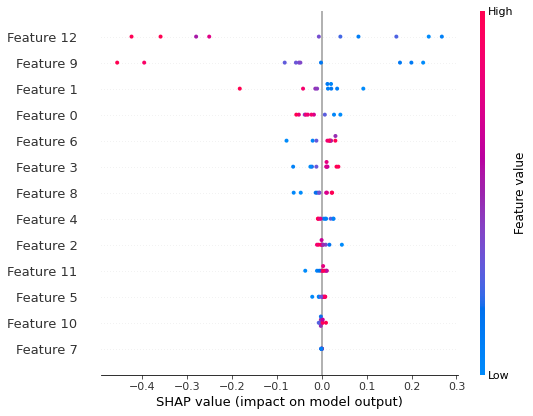

In [40]:
shap.initjs()
# shap.plots.force(LR_shap[0])
# shap.force_plot(LR_expected_val_k, LR_shap_k[0], X_test[0])
shap.summary_plot(LR_shap_k, X_test[:10,])

In [41]:
# shap.initjs()
# shap.plots.force(RF_shap[0])

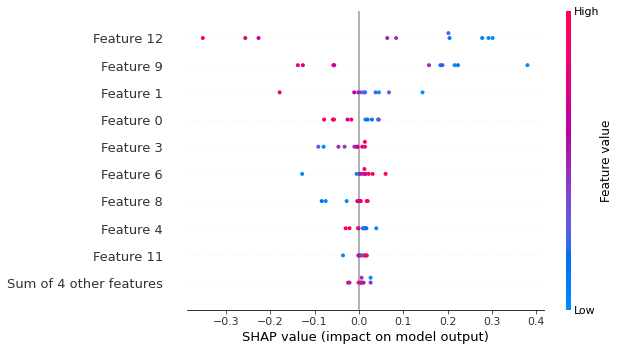

In [35]:
shap.initjs()
visualize_shap(X = X_test[0],
               shap_value = LR_shap,
               expected_value = LR_baseVal,
               type_of_Vis = "beeswarm",
               explainer_type = "shap")

In [35]:
RF_shap, RF_baseVal = Explanation("SHAP",predict_fnRF,X_test[:10,],X100)
# RF_shap_k,RF_expected_val_k = Explanation("Kernel SHAP",predict_fnRF,X_test[10:,],X100)


In [36]:
RF_shap_k,RF_expected_val_k = Explanation("Kernel SHAP",predict_fnRF,X_test[:10,],X100_)


  0%|          | 0/10 [00:00<?, ?it/s]

In [37]:
RF_lime1 = Explanation("LIME",RF_model.predict_proba,X_test[:10,],X100)


In [38]:
# RF_lime = Explanation("LIME-SHAP",predict_fnRF,X_test,X100)

In [39]:
SVC_shap, SVC_baseVal = Explanation("SHAP",predict_fnSVC,X_testS[:10,],X100)
SVC_shap_k,SVC_expected_val_k = Explanation("Kernel SHAP",predict_fnSVC,X_testS[:10,],X100_)


  0%|          | 0/10 [00:00<?, ?it/s]

In [40]:
SVC_lime1 = Explanation("LIME",SVC_model.predict_proba,X_testS[:10,],X100)
# SVC_lime = Explanation("LIME-SHAP",predict_fnSVC,X_testS,X100)

In [48]:
print((X_test[0].reshape(-1,1)).shape)

(13, 1)


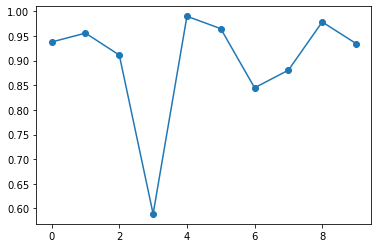

0.8985954702144449


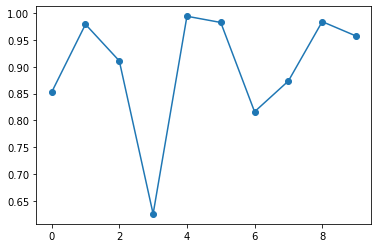

0.8978834306598044


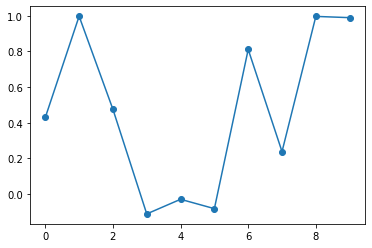

0.4711656429773079


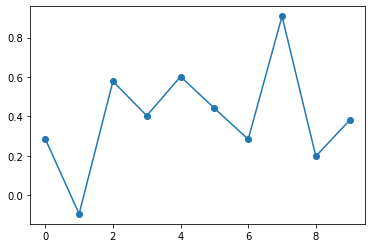

0.3984003835150013


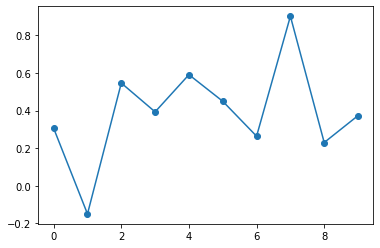

0.3907373500576613


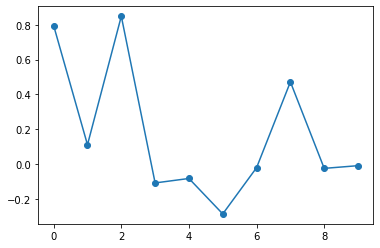

0.16904056704935108


In [69]:
faithfulness_LR_shap= metrics(model=LR_model,X=X_test[:10,],shap_val=LR_shap,explainer_type="shap",metrics_type="faithfulness",dataset="wine")
print(np.mean(np.array(faithfulness_LR_shap)))
faithfulness_LR_shap_k = metrics(model=LR_model,X=X_test[:10,],shap_val=LR_shap_k,explainer_type="kernel shap",metrics_type="faithfulness",dataset="wine")
print(np.mean(np.array(faithfulness_LR_shap_k)))
faithfulness_LR_lime = metrics(model=LR_model,X=X_test[:10,],shap_val=LR_lime1,explainer_type="lime",metrics_type="faithfulness",dataset="wine")
print(np.mean(np.array(faithfulness_LR_lime)))
faithfulness_RF_shap= metrics(model=RF_model,X=X_test[:10,],shap_val=RF_shap,explainer_type="shap",metrics_type="faithfulness",dataset="wine")
print(np.mean(np.array(faithfulness_RF_shap)))
faithfulness_RF_shap_k = metrics(model=RF_model,X=X_test[:10,],shap_val=RF_shap_k,explainer_type="kernel shap",metrics_type="faithfulness",dataset="wine")
print(np.mean(np.array(faithfulness_RF_shap_k)))
faithfulness_RF_lime = metrics(model=RF_model,X=X_test[:10,],shap_val=RF_lime1,explainer_type="lime",metrics_type="faithfulness",dataset="wine")
print(np.mean(np.array(faithfulness_RF_lime)))


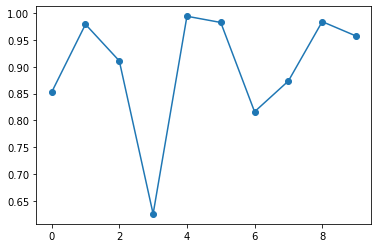

0.8978834306598044


In [70]:
faithfulness_LR_shap_k = metrics(model=LR_model,X=X_test[:10,],shap_val=LR_shap_k,explainer_type="kernel shap",metrics_type="faithfulness",dataset="dataset")
print(np.mean(np.array(faithfulness_LR_shap_k)))

In [53]:
np.mean(np.abs(np.array(faithfulness_LR_shap)))

0.8985954702144449

In [43]:
X_test.shape

(45, 13)

In [44]:
LR_model.predict_proba(np.transpose(X_test[0].reshape(-1,1)))

array([[0.10236865, 0.66674672, 0.23088463]])

In [45]:
RF_shap[0].shape

(13,)

In [46]:
LR_shap[0].shape

(13,)

In [47]:
LR_shap_k[0].shape

(13,)

In [48]:
RF_shap_k[0].shape

(13,)

In [49]:
SVC_shap.shape

(10, 13, 3)

In [42]:
vv = np.array(SVC_shap_k)
vv.shape,vv[:,0,:].shape

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [41]:
pred_class = np.argmax(SVC_model.predict_proba(X_testS[:10,]), axis=1)
print(pred_class)
print(pred_class.shape)
# SVC_shap.values[:,pred_class]
# pred_class
# np.argmax(SVC_model.predict_proba(X_test), axis=1),SVC_model.predict_proba(X_test)
x = X_testS[:10,]
s=SVC_shap.values[:10,]
o = []
for i in range(x.shape[0]):
    p = pred_class[i]
    o.append(s[i,:,p])
o_ = np.array(o)
o_.shape

[1 1 0 1 0 0 1 1 0 1]
(10,)


IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

og pred 0.8433603868626336
[-5.06505713e-02  9.27165110e-02  4.50285303e-02 -2.15285856e-02
  2.01618196e-02  2.77126242e-03  3.07606677e-02 -1.08247926e-04
 -4.64445197e-02  1.74296366e-01  9.71494948e-03  1.01028941e-02
  1.66225789e-01] [-4.92594848e-02  1.75884237e-01  6.60721021e-02 -5.64811762e-02
  1.27747327e-02 -3.47734191e-03 -1.62199059e-02 -9.54185865e-06
 -6.82886822e-02  6.48063744e-01  1.86537861e-02 -4.60254597e-04
  3.99970997e-01]
og pred 0.9999763492229022
[-3.47738214e-02  1.29679042e-02 -4.18220804e-05 -2.49328256e-02
  4.73541096e-03  4.52792209e-03  2.11113328e-02  1.85640422e-04
  1.00902379e-02 -5.05455421e-02  1.12768623e-03  3.40571798e-03
 -3.58169730e-01] [ 7.51374322e-06 -5.83988471e-06  1.23786377e-06  4.75867312e-05
  1.09853363e-05  5.35043141e-06  5.59772602e-05 -2.02487813e-07
  4.72208491e-06 -8.66315615e-07  9.87714917e-07  1.48033166e-05
  3.17997682e-02]
og pred 0.9852975772356918
[-0.0170971   0.03453815  0.00922383  0.03730068  0.02554041 -0.001

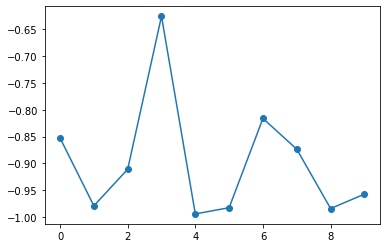

In [54]:
faithfulness_LR_shap_k = metrics(model=LR_model,X=X_test[:10,],shap_val=LR_shap_k,explainer_type="kernel shap",metrics_type="faithfulness",dataset="dataset")


In [55]:
np.mean(np.array(faithfulness_LR_shap_k))

-0.8978834306598044

In [88]:
shap.initjs()
shap.force_plot(LR_expected_val_k,LR_shap_k[4],X_test[4])

In [89]:
y_test[4]

2

In [55]:
# pred_class = np.argmax(model.predict_proba(np.transpose(x.reshape(-1,1))), axis=1)[0]
#     pred_prob = model.predict_proba(np.transpose(x.reshape(-1,1)))
#     ar = np.argsort(-coefs)  #argsort returns indexes of values sorted in increasing order; so do it for negated array
#     pred_probs = np.zeros(x.shape[0])
#     diff = []
#     for ind in np.nditer(ar):
#         x_copy = x.copy()
#         x_copy[ind] = base[ind]
        
#         x_copy_pr = model.predict_proba(x_copy.reshape(1,-1))
#         pred_probs[ind] = x_copy_pr[0][pred_class]

In [56]:
np.argmax(SVC_model.predict_proba(X_testS[10:,]), axis=1)

array([0, 1, 0, 2, 2, 2, 1, 0, 1, 1, 2, 0, 1, 2, 0, 0, 2, 0, 0, 0, 2, 0,
       2, 0, 2, 1, 1, 0, 1, 1, 0, 0, 0, 2, 1])

In [57]:
SVC_shap.values[1,:,1].shape

(13,)

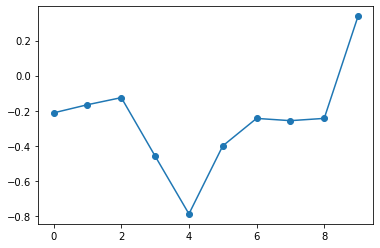

In [66]:
faithfulness_SVC_shap= metrics(model=SVC_model,X=X_testS[:10,],shap_val=o_,explainer_type="shap",metrics_type="faithfulness",dataset="dataset")


In [67]:
np.mean(np.abs(np.array(faithfulness_SVC_shap)))

0.25577660252184

In [60]:
X_testS[:10,].shape,SVC_shap.values[:10,].shape

((10, 13), (10, 13, 3))

In [61]:
pred_class = np.argmax(SVC_model.predict_proba(X_testS[:10,]), axis=1)
print(pred_class)
print(pred_class.shape)
# SVC_shap.values[:,pred_class]
# pred_class
# np.argmax(SVC_model.predict_proba(X_test), axis=1),SVC_model.predict_proba(X_test)
x = X_testS[:10,]
sk=np.array(SVC_shap_k)[:10,]
ok = []
for i in range(x.shape[0]):
    p = pred_class[i]
    ok.append(sk[p,i,:])
o_k= np.array(ok)
o_k.shape

[2 2 1 0 1 1 0 1 1 2]
(10,)


(10, 13)

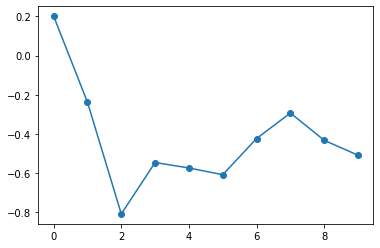

-0.4234683103084599

In [62]:
faithfulness_SVC_k_shap= metrics(model=SVC_model,X=X_testS[:10,],shap_val=o_k,explainer_type="shap",metrics_type="faithfulness",dataset="dataset")
np.mean(np.array(faithfulness_SVC_k_shap))

In [63]:
np.array(SVC_lime1).shape

(10, 13)

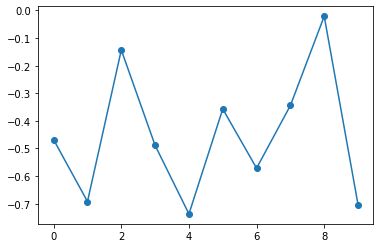

-0.4527424476880529

In [64]:
faithfulness_SVC_lime= metrics(model=SVC_model,X=X_testS[:10,],shap_val=np.array(SVC_lime1),explainer_type="lime",metrics_type="faithfulness",dataset="dataset")
np.mean(np.array(faithfulness_SVC_lime))

In [65]:
LR_shap[0]

.values =
array([-0.02584265,  0.14324621,  0.01025689, -0.04635396, -0.02136375,
        0.00368082,  0.00733909,  0.00129884, -0.07506366,  0.1882716 ,
        0.00255048,  0.00601421,  0.06373816])

.base_values =
0.41650458590288836

.data =
array([1.334e+01, 9.400e-01, 2.360e+00, 1.700e+01, 1.100e+02, 2.530e+00,
       1.300e+00, 5.500e-01, 4.200e-01, 3.170e+00, 1.020e+00, 1.930e+00,
       7.500e+02])

In [66]:
y_test,type(LR_lime1)

(array([1, 1, 1, 0, 2, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 2, 1, 2,
        1, 2, 0, 1, 0, 0, 1, 2, 1, 0, 2, 1, 1, 2, 2, 2, 1, 2, 1, 2, 1, 0,
        1]),
 list)

In [67]:
monotonicity_LR_shap = metrics(model=LR_model,X=X_test[:10,],shap_val=LR_shap,explainer_type="shap",metrics_type="monotonicity",dataset=dataset1)
monotonicity_LR_shap_k = metrics(model=LR_model,X=X_test[:10,],shap_val=LR_shap_k ,explainer_type="shap",metrics_type="monotonicity",dataset=dataset1)
monotonicity_LR_lime = metrics(model=LR_model,X=X_test[:10,],shap_val=LR_lime1,explainer_type="lime",metrics_type="monotonicity",dataset=dataset1)
monotonicity_RF_shap = metrics(model=RF_model,X=X_test[:10,],shap_val=RF_shap,explainer_type="shap",metrics_type="monotonicity",dataset=dataset1)
monotonicity_RF_shap_k = metrics(model=RF_model,X=X_test[:10,],shap_val=RF_shap_k,explainer_type="shap",metrics_type="monotonicity",dataset=dataset1)
monotonicity_RF_lime = metrics(model=RF_model,X=X_test[:10,],shap_val=RF_lime1,explainer_type="lime",metrics_type="monotonicity",dataset=dataset1)

monotonicity_SVC_lime = metrics(model=SVC_model,X=X_testS[:10,],shap_val=SVC_lime1,explainer_type="lime",metrics_type="monotonicity",dataset=dataset1)

NameError: name 'dataset1' is not defined

In [65]:
pred_class1 = np.argmax(SVC_model.predict_proba(X_testS[:10,]), axis=1)
x = X_testS[:10,]
s=SVC_shap.values[:10,]
o = []
for i in range(x.shape[0]):
    p = pred_class1[i]
    o.append(s[i,:,p])
o_ = np.array(o)

    
    
pred_class = np.argmax(SVC_model.predict_proba(X_testS[:10,]), axis=1)
x = X_testS[:10,]
sk=np.array(SVC_shap_k)[:10,]
ok = []
for i in range(x.shape[0]):
    p = pred_class[i]
    ok.append(sk[p,i,:])
o_k= np.array(ok)

    
monotonicity_SVC_shap = metrics(model=SVC_model,X=X_testS[:10,],shap_val=o_,explainer_type="shap",metrics_type="monotonicity",dataset=dataset)
monotonicity_SVC_shap_k = metrics(model=SVC_model,X=X_testS[:10,],shap_val=o_k,explainer_type="shap",metrics_type="monotonicity",dataset=dataset)


NameError: name 'dataset' is not defined

In [69]:

monotonicity_LR_shap,
monotonicity_LR_shap_k,
monotonicity_LR_lime,
monotonicity_RF_shap,
monotonicity_RF_shap_k,
monotonicity_RF_lime,
monotonicity_SVC_shap,
monotonicity_SVC_shap_k,
monotonicity_SVC_lime

NameError: name 'monotonicity_LR_shap' is not defined

In [94]:
type(LR_shap)

shap._explanation.Explanation

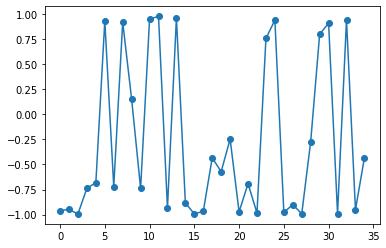

In [80]:
mono_LR_shap= metrics(model=LR_model,X=X_test[10:,],shap_val=LR_shap,explainer_type="shap",metrics_type="faithfulness",dataset="dataset")
# faithfulness_RF_shap = metrics(model=RF_model,X=X_test[10:,],shap_val=LR_shap,explainer_type="shap",metrics_type="faithfulness",dataset="dataset")
# faithfulness_RF_lime = metrics(model=RF_model,X=X_test[100:,],shap_val=RF_lime,explainer_type="lime",metrics_type="faithfulness",dataset=dataset)
# faithfulness_LR_shap_k = metrics(model=LR_model,X=X_test[10:,],shap_val=LR_shap_k,explainer_type="shap",metrics_type="faithfulness",dataset="dataset")
# faithfulness_RF_shap_k = metrics(model=RF_model,X=X_test[100:,],shap_val=RF_shap_k,explainer_type="shap",metrics_type="faithfulness",dataset="dataset")

# monotonicity_LR_lime = metrics(model=LR_model,X=X_test[100:,],shap_val=LR_lime,explainer_type="lime",metrics_type="monotonicity",dataset=dataset)
# monotonicity_RF_shap = metrics(model=RF_model,X=X_test[100:,],shap_val=RF_shap,explainer_type="shap",metrics_type="monotonicity",dataset=dataset)
# monotoni

In [65]:
np.mean(np.array(faithfulness_LR_shap))

-0.13183368610140456

In [ ]:
def faithfulness_metrics_cls(model,x,coefs,base):
    pred_class = np.argmax(model.predict_proba(np.transpose(x.reshape(-1,1))), axis=1)[0]
    pred_prob = np.ama
    ar = np.argsort(-coefs)  #argsort returns indexes of values sorted in increasing order; so do it for negated array
    pred_probs = np.zeros(x.shape[0])
    diff = []
    for ind in np.nditer(ar):
        x_copy = x.copy()
        d = x_copy[ind]-base[ind]
#         if d<0:
#             diff.append(-1)
#         else:
#             diff.append(1)
        x_copy[ind] = base[ind]
        
        x_copy_pr = model.predict_proba(x_copy.reshape(1,-1))
        pred_probs[ind] = x_copy_pr[0][pred_class]
        # print(pred_probs)
        # print(pred_class)

    return -np.corrcoef(coefs, pred_probs-pred)[0,1]

In [66]:
np.mean(np.array(faithfulness_LR_shap_k))

-0.15884822922728817

In [56]:
# LR_shap_k

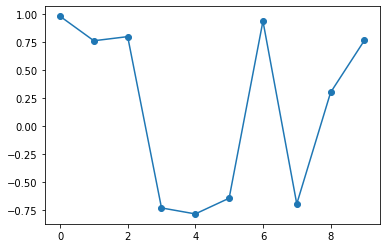

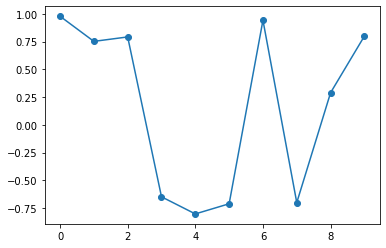

In [71]:
faithfulness_RF_shap = metrics(model=RF_model,X=X_test[:10,],shap_val=RF_shap,explainer_type="shap",metrics_type="faithfulness",dataset="dataset")
faithfulness_RF_shap_k = metrics(model=RF_model,X=X_test[:10,],shap_val=RF_shap_k,explainer_type="kernel shap",metrics_type="faithfulness",dataset="dataset")


In [72]:
np.mean(np.array(faithfulness_RF_shap))

0.16895228090683406

In [73]:
np.mean(np.array(faithfulness_RF_shap_k))

0.16898065066457296

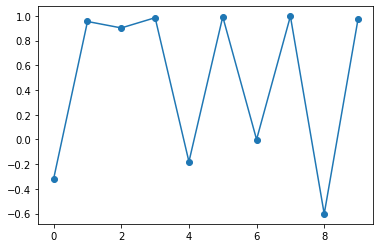

In [74]:
# faithfulness_SVC_shap = metrics(model=SVC_model,X=X_testS[10:,],shap_val=SVC_shap,explainer_type="shap",metrics_type="faithfulness",dataset="")
faithfulness_LR_lime = metrics(model=LR_model,X=X_test[:10,],shap_val=LR_lime1,explainer_type="lime",metrics_type="faithfulness",dataset="dataset")
# faithfulness_RF_shap = metrics(model=RF_model,X=X_test[100:,],shap_val=RF_shap,explainer_type="shap",metrics_type="faithfulness",dataset="dataset")
# faithfulness_RF_lime = metrics(model=RF_model,X=X_test[100:,],shap_val=RF_lime,explainer_type="lime",metrics_type="faithfulness",dataset=dataset)
# faithfulness_LR_shap_k = metrics(model=LR_model,X=X_test[100:,],shap_val=LR_shap_k,explainer_type="shap",metrics_type="faithfulness",dataset="dataset")
# faithfulness_RF_shap_k = metrics(model=RF_model,X=X_test[100:,],shap_val=RF_shap_k,explainer_type="shap",metrics_type="faithfulness",dataset="dataset")

# monotonicity_LR_lime = metrics(model=LR_model,X=X_test[100:,],shap_val=LR_lime,explainer_type="lime",metrics_type="monotonicity",dataset=dataset)
# monotonicity_RF_shap = metrics(model=RF_model,X=X_test[100:,],shap_val=RF_shap,explainer_type="shap",metrics_type="monotonicity",dataset=dataset)
# monotonicity_RF_lime = metrics(model=RF_model,X=X_test[100:,],shap_val=RF_lime,explainer_type="lime",metrics_type="monotonicity",dataset=dataset)


In [75]:
np.mean(np.array(faithfulness_LR_lime))

0.47034484554971456

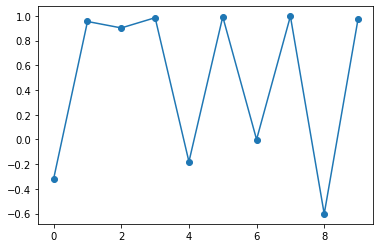

0.47034484554971456

In [76]:
faithfulness_RF_lime = metrics(model=LR_model,X=X_test[:10,],shap_val=RF_lime1,explainer_type="lime",metrics_type="faithfulness",dataset="dataset")
np.mean(np.array(faithfulness_RF_lime))

In [77]:
LR_shap.shape

(10, 13)

In [78]:
 X_test[0].shape,x.reshape(1,-1).shape

((13,), (1, 130))

In [79]:
# monotonicity_LR_shap = metrics(model=LR_model,X=X_test[:35,],shap_val=LR_shap,explainer_type="shap",metrics_type="monotonicity",dataset="dataset")


In [80]:
# monotonicity(model, x, coefs, base)

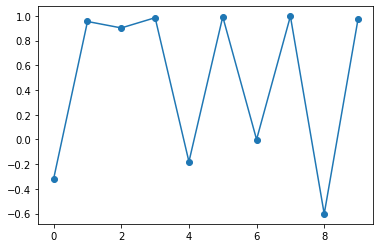

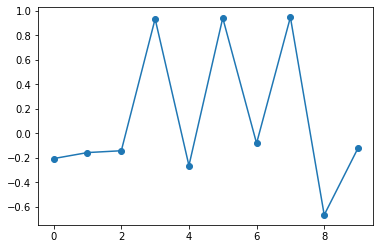

In [83]:
# faithfulness_LR_shap = metrics(model=LR_model,X=X_test[100:,],shap_val=LR_shap,explainer_type="shap",metrics_type="faithfulness",dataset=dataset)
faithfulness_LR_lime = metrics(model=LR_model,X=X_test[:10,],shap_val=LR_lime1,explainer_type="lime",metrics_type="faithfulness",dataset="ds")
# faithfulness_RF_shap = metrics(model=RF_model,X=X_test[100:,],shap_val=RF_shap,explainer_type="shap",metrics_type="faithfulness",dataset=dataset)
faithfulness_RF_lime = metrics(model=RF_model,X=X_test[:10,],shap_val=RF_lime1,explainer_type="lime",metrics_type="faithfulness",dataset="dataset")
# faithfulness_LR_shap_k = metrics(model=LR_model,X=X_test[100:,],shap_val=LR_shap_k,explainer_type="shap",metrics_type="faithfulness",dataset=dataset)
# faithfulness_RF_shap_k = metrics(model=RF_model,X=X_test[100:,],shap_val=RF_shap_k,explainer_type="shap",metrics_type="faithfulness",dataset=dataset)

# monotonicity_LR_shap = metrics(model=LR_model,X=X_test[100:,],shap_val=LR_shap,explainer_type="shap",metrics_type="monotonicity",dataset=dataset)
# monotonicity_LR_lime = metrics(model=LR_model,X=X_test[100:,],shap_val=LR_lime,explainer_type="lime",metrics_type="monotonicity",dataset=dataset)
# monotonicity_RF_shap = metrics(model=RF_model,X=X_test[100:,],shap_val=RF_shap,explainer_type="shap",metrics_type="monotonicity",dataset=dataset)
# monotonicity_RF_lime = metrics(model=RF_model,X=X_test[100:,],shap_val=RF_lime,explainer_type="lime",metrics_type="monotonicity",dataset=dataset)


In [ ]:
def Main(dataset):
  X,y = loadDataset(dataset)
  sc = StandardScaler()
  X_scaled = sc.fit_transform(X)
  X_train,X_test,y_train,y_test = train_test_split(X,y)
  X_trainS,X_testS,y_trainS,y_testS = train_test_split(X_scaled,y)
  
  LR_model = train_model("Logistic Regression",X_train,y_train)
  RF_model = train_model("Random Forest Classifier",X_train,y_train)
  SVC_model = train_model("SVC",X_trainS,y_trainS)

  print("====================================================================")
  print("Logistic Regression:")
  print('R2 for Train)', RF_model.score( X_train, y_train ))
  print('R2 for Test (cross validation)', RF_model.score(X_test, y_test))
  print("====================================================================")
  print("Random Forest Classifier:")
  print('R2 for Train)', LR_model.score( X_train, y_train ))
  print('R2 for Test (cross validation)', LR_model.score(X_test, y_test)) 
  print("====================================================================")
  print("SVM Classifier:")
  print('R2 for Train)', SVC_model.score( X_trainS, y_trainS))
  print("====================================================================")
  predict_fnLR = lambda x:LR_model.predict_proba(x)[:,1]
  predict_fnRF = lambda x:RF_model.predict_proba(x)[:,1]
  predict_fnSVC = SVC_model.decision_function 

  X100 = shap.maskers.Independent(X, max_samples=100)
  X_100 = shap.utils.sample(X, 1000)
  LR_shap,LR_baseVal = Explanation("SHAP",LR_model,X_test.iloc[100:,],X100)
  LR_shap_k,RF_expected_val_k = Explanation("Kernel SHAP",LR_model,X_test.iloc[100:,],X100)
  LR_lime1 = Explanation("LIME",LR_model,X_test,X100)
  LR_lime = Explanation("LIME-SHAP",LR_model,X_test,X100)

  RF_shap, RF_baseVal = Explanation("SHAP",RF_model,X_test.iloc[100:,],X100)
  RF_shap_k,RF_expected_val_k = Explanation("Kernel SHAP",RF_model,X_test.iloc[100:,],X100)
  RF_lime1 = Explanation("LIME",RF_model,X_test,X100)
  RF_lime = Explanation("LIME-SHAP",RF_model,X_test,X100)

  faithfulness_LR_shap = metrics(model=LR_model,X=X_test.iloc[100:,],shap_val=LR_shap,explainer_type="shap",metrics_type="faithfulness",dataset=dataset)
  # faithfulness_LR_lime = metrics(model=LR_model,X=X_test.iloc[100:,],shap_val=LR_lime,explainer_type="lime",metrics_type="faithfulness",dataset=dataset)
  faithfulness_RF_shap = metrics(model=RF_model,X=X_test.iloc[100:,],shap_val=RF_shap,explainer_type="shap",metrics_type="faithfulness",dataset=dataset)
  # faithfulness_RF_lime = metrics(model=RF_model,X=X_test.iloc[100:,],shap_val=RF_lime,explainer_type="lime",metrics_type="faithfulness",dataset=dataset)
  faithfulness_LR_shap_k = metrics(model=LR_model,X=X_test.iloc[100:,],shap_val=LR_shap_k,explainer_type="shap",metrics_type="faithfulness",dataset=dataset)
  faithfulness_RF_shap_k = metrics(model=RF_model,X=X_test.iloc[100:,],shap_val=RF_shap_k,explainer_type="shap",metrics_type="faithfulness",dataset=dataset)

  monotonicity_LR_shap = metrics(model=LR_model,X=X_test.iloc[100:,],shap_val=LR_shap,explainer_type="shap",metrics_type="monotonicity",dataset=dataset)
  # monotonicity_LR_lime = metrics(model=LR_model,X=X_test.iloc[100:,],shap_val=LR_lime,explainer_type="lime",metrics_type="monotonicity",dataset=dataset)
  monotonicity_RF_shap = metrics(model=RF_model,X=X_test.iloc[100:,],shap_val=RF_shap,explainer_type="shap",metrics_type="monotonicity",dataset=dataset)
  # monotonicity_RF_lime = metrics(model=RF_model,X=X_test.iloc[100:,],shap_val=RF_lime,explainer_type="lime",metrics_type="monotonicity",dataset=dataset)


  print("====================================================================")
  print("faithfulness for SHAP explainer for Linear regression",faithfulness_LR_shap)
  print("====================================================================")
  # print("faithfulness for lime explainer for Linear regression",faithfulness_LR_lime)
  print("====================================================================")
  print("faithfulness for SHAP explainer for Linear regression",faithfulness_RF_shap)
  print("====================================================================")
  # print("faithfulness for lime explainer for Linear regression",faithfulness_RF_lime)
  print("====================================================================")
  print(monotonicity_LR_shap)
  print("====================================================================")
  # print(monotonicity_LR_lime.any())
  print("====================================================================")
  print(monotonicity_RF_shap)
  print("====================================================================")
  # print(monotonicity_RF_lime.any())
  print("====================================================================")
#monotonicity_RF_lime,faithfulness_LR_lime,faithfulness_RF_lime,monotonicity_LR_lime
  return faithfulness_RF_shap,monotonicity_LR_shap,monotonicity_RF_shap,faithfulness_LR_shap

scratchpad

In [87]:
fv= np.array([[1,3,4],[5,6,4],[4,8,4],[9,9,9],[2,6,2],[7,1,2]])
fv[:,1],fv

(array([3, 6, 8, 9, 6, 1]),
 array([[1, 3, 4],
        [5, 6, 4],
        [4, 8, 4],
        [9, 9, 9],
        [2, 6, 2],
        [7, 1, 2]]))

R2 for Train) 1.0
R2 for Test (cross validation) 1.0
R2 for Train) 0.9924812030075187
R2 for Test (cross validation) 1.0
R2 for Train) 1.0


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

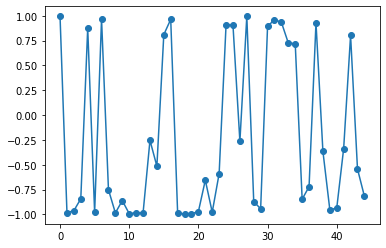

Mean Faithfulness for shap Logistic reg: -0.23295104452503865


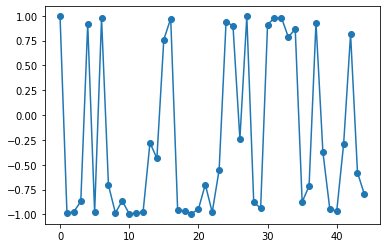

Mean Faithfulness for kernel shap Logistic reg: -0.22232019591959074


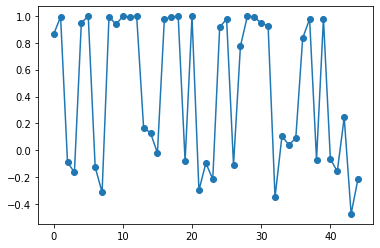

Mean Faithfulness for lime Logistic Reg: 0.44323174678959615


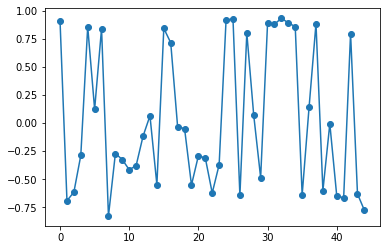

Mean Faithfulness for shap RF Classification: 0.03451640846327556


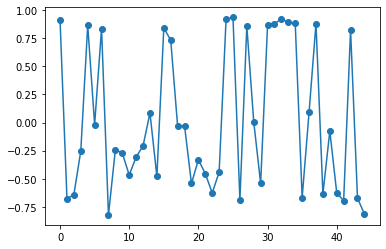

Mean Faithfulness for kernel shap RF Classification: 0.021785090436453436


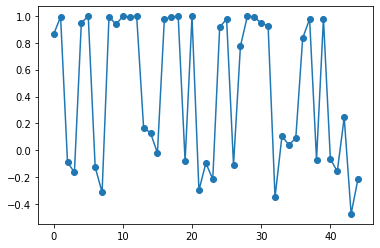

Mean Faithfulness for lime RF Classification: 0.44323174678959615


In [27]:
dataset = "wine"
Main(dataset)